<a href="https://colab.research.google.com/github/zahraa57/Machine-Learning-1-Course-Project/blob/main/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random as rd
rd.seed(0)

In [2]:
#import libraries
%%capture
!pip install mediapipe

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin
import os,cv2
import mediapipe as mp


from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR


import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('/content/drive/MyDrive/data/data.csv')
features = data.drop(["image_name","pitch","yaw","roll","h","v","t","scale"], axis=1)
labels = data[["pitch","yaw","roll"]]
labels=labels.round(decimals=2)

In [4]:
scaler= MinMaxScaler()
pca=PCA(n_components=6)  

In [5]:
# remark: we fix random_state the end, to make sure we always get the same results
features_train, features_validation_test, labels_train, labels_validation_test = train_test_split(
    features, labels, test_size=0.2, random_state=100)

In [6]:
features_validation, features_test, labels_validation, labels_test = train_test_split(
    features_validation_test, labels_validation_test, test_size=0.1, random_state=100)

In [7]:
svr = MultiOutputRegressor(SVR())
parameters = {'estimator__kernel': ['rbf'], 'estimator__C':[10,20],'estimator__gamma': [1e-7, 1e-10],'estimator__epsilon':[0.1,0.05]}
svr_gs = GridSearchCV(svr, parameters)
#svr_gs.fit(features_train,labels_train)
#clf.best_params_
#svr_gs.score(features_validation,labels_validation)

In [8]:
PIPE_LINE_svr =make_pipeline(scaler,pca,svr_gs).fit(features_train, labels_train)
print(PIPE_LINE_svr.score(features_train, labels_train))
print(PIPE_LINE_svr.score(features_validation,labels_validation))

-0.00034615551665669503
-0.00018486223038275776


In [9]:
x=pd.DataFrame(features_validation.iloc[1]).to_numpy().reshape(1,-1)

In [10]:
x.shape

(1, 936)

In [11]:
PIPE_LINE_svr.predict(x)

array([[-0.11003383,  0.01989004, -0.01959698]])

In [12]:
def feature_extract(image):
  x=[]
  y=[]

  mp_face_mesh=mp.solutions.face_mesh.FaceMesh()
  result=mp_face_mesh.process(image)
  height,width,_=image.shape 
  if result.multi_face_landmarks != None: 
    for facial_landmarks in result.multi_face_landmarks:
      for i in range(0,468):
        pt1=facial_landmarks.landmark[i]
        #print(pt1)
        x.append(pt1.x)
        y.append(pt1.y)
  z=pd.DataFrame(np.array([*x,*y]).reshape(1,-1))
  return z

In [13]:
def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size=50):
    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

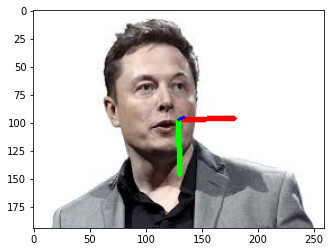

In [14]:
image = cv2.imread("/content/drive/MyDrive/data/images.jpg")
z= feature_extract(image)
y=PIPE_LINE_svr.predict(z)
res_img=draw_axis(np.asarray(image),y[0][0],y[0][1],y[0][2])
plt.imshow(cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB))

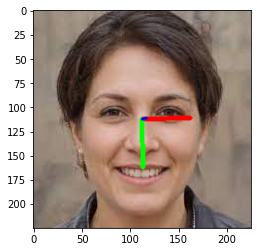

In [15]:
image = cv2.imread("/content/drive/MyDrive/data/download.jpg")
z= feature_extract(image)
y=PIPE_LINE_svr.predict(z)
res_img=draw_axis(np.asarray(image),y[0][0],y[0][1],y[0][2])
plt.imshow(cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB))

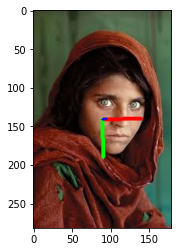

In [16]:
image = cv2.imread("/content/drive/MyDrive/data/images2.jpg")
z= feature_extract(image)
y=PIPE_LINE_svr.predict(z)
res_img=draw_axis(np.asarray(image),y[0][0],y[0][1],y[0][2])
plt.imshow(cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB))

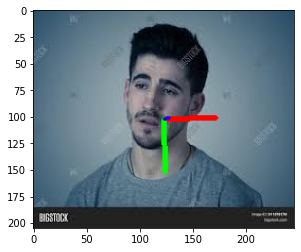

In [17]:
image = cv2.imread("/content/drive/MyDrive/data/images1.jpg")
z= feature_extract(image)
y=PIPE_LINE_svr.predict(z)
res_img=draw_axis(np.asarray(image),y[0][0],y[0][1],y[0][2])
plt.imshow(cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB))

In [18]:
import pickle

In [19]:
filename = '/content/drive/MyDrive/data/svrmodel.sav'
pickle.dump(PIPE_LINE_svr, open(filename, 'wb'))
 
# load the model 
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(features_test, labels_test)
print(result)

-0.059864641127631645


In [20]:
from google.colab.patches import cv2_imshow
#video with media pipe
c=[]
mp_face_mesh=mp.solutions.face_mesh.FaceMesh()

cap=cv2.VideoCapture('/content/drive/MyDrive/data/video.mp4')
fourcc=cv2.VideoWriter_fourcc(*'XVID')
out =cv2.VideoWriter('/content/drive/MyDrive/data/output.avi',fourcc,20.0,(432,832))
                         
print(cap.isOpened())
while(cap.isOpened()):
    ret,frame= cap.read()
    if ret== True:
        #print(frame.shape)
        c.append(frame)
        z= feature_extract(frame)
        if z.shape[1]>0:
          y=PIPE_LINE_svr.predict(z)
          res_img=draw_axis(np.asarray(frame),y[0][0],y[0][1],y[0][2])  
          out.write(res_img)
          #cv2_imshow(res_img)

    else:
        break
cap.release()
out.release()
cv2.destroyAllWindows()


True


In [25]:
print(c[20].shape)

(432, 832, 3)
